In [1]:
import pandas as pd
from haversine import haversine, Unit
import numpy as np
from scipy.spatial.distance import cdist
import seaborn as sns
from geopy.distance import great_circle
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
bus = pd.read_csv('CTA_BusStops_Cleaned.csv')
mcmf = pd.read_csv('data_cleaned.csv')

/var/folders/tx/ccgvwwd562sfhw5ybj094vxc0000gn/T/ipykernel_16022/2349858161.py:2: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  mcmf = pd.read_csv('data_cleaned.csv')


In [33]:
train = pd.read_csv('CTA_TrainStops.csv')

In [3]:
bus = bus.drop('Unnamed: 0', axis=1)
mcmf = mcmf.drop('Unnamed: 0', axis=1)

In [4]:
bus = bus.rename(columns={'latitude': 'longitude', 'longitude': 'latitude'})
bus.head(2)

,longitude,latitude,the_geom,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,PUBLIC_NAM
0,-87.747509,41.956892,POINT (-87.74750923800002 41.956892084),15189,CICERO,BERTEAU (north leg),SB,FS,"54,54A",NaN,CHICAGO,Cicero & Berteau
1,-87.641786,41.677992,POINT (-87.64178572600002 41.67799153599998),14545,HALSTED,119TH STREET,NB,FS,"8A,108",NaN,CHICAGO,Halsted & 119th Street


In [5]:
mcmf.head(2)

# row1, col1 is dist of first program to first bus stop

,index_row,id,program_name,description,org_name,category_name,capacity,min_age,max_age,meeting_type,...,wed_end_time,wed_start_time,program_price,geographic_cluster_name,program_pays_participants,program_has_scholarships,program_provides_transportation,latitude,longitude,program_provides_free_food
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,academic_support,2000.0,7,15,face_to_face,...,NaN,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,work_career,2000.0,7,15,face_to_face,...,NaN,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False


In [6]:
bus_coords = bus[['latitude', 'longitude']].to_numpy()

In [7]:
mcmf_coords = mcmf[['latitude', 'longitude']].to_numpy()

In [8]:
mcmf_coords

array([[ 41.88600159, -87.64240265],
       [ 41.88600159, -87.64240265],
       [ 41.8647995 , -87.72480011],
       ...,
       [ 41.92909241, -87.73815155],
       [ 41.92909241, -87.73815155],
       [ 41.92909241, -87.73815155]])

In [9]:
# Convert to radians
mcmf_in_radians = np.array([[radians(float(x)) for x in coord] for coord in mcmf_coords])
bus_in_radians = np.array([[radians(float(x)) for x in coord] for coord in bus_coords])

In [10]:
# Calculate haversine dists then convert to km
dists = haversine_distances(mcmf_in_radians, bus_in_radians)
dists_km = dists*6371 # multiply by radius of Earth

In [11]:
# Indices of bus stops that are closest to each program
min_idx = np.argmin(dists_km, axis=1)

In [12]:
# Minimum distances to each bus stop
min_dist = np.nanmin(dists_km, axis=1)
min_dist

/var/folders/tx/ccgvwwd562sfhw5ybj094vxc0000gn/T/ipykernel_16022/2256880577.py:2: RuntimeWarning: All-NaN slice encountered
  min_dist = np.nanmin(dists_km, axis=1)


array([0.04927228, 0.04927228, 0.04351932, ..., 0.29226811, 0.29226811,
       0.29226811])

In [13]:
# Shape is 72790, which is same as # cols of mcmf df
min_dist.shape

(72790,)

In [14]:
mcmf['km_to_bus_stop'] = min_dist

In [34]:
mcmf.head(2)

,index_row,id,program_name,description,org_name,category_name,capacity,min_age,max_age,meeting_type,...,wed_start_time,program_price,geographic_cluster_name,program_pays_participants,program_has_scholarships,program_provides_transportation,latitude,longitude,program_provides_free_food,km_to_bus_stop
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,academic_support,2000.0,7,15,face_to_face,...,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,0.049272
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,work_career,2000.0,7,15,face_to_face,...,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,0.049272


#### Train

In [35]:
train.head(2)

,STOP_ID,STOP_NAME,STATION_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30082,Cicero (Loop-bound),Cicero,40420,True,False,False,False,False,False,False,False,True,False,"(41.85182, -87.745336)"
1,30151,Central Park (Loop-bound),Central Park,40780,True,False,False,False,False,False,False,False,True,False,"(41.853839, -87.714842)"


In [39]:
def extract_latitude_longitude(location):
    if isinstance(location, str):
        # Extract latitude and longitude from string format
        lat, lon = location.split(',')
        lat = lat.strip().replace('(', '')
        lon = lon.strip().replace(')', '')
        return float(lat), float(lon)
    elif isinstance(location, tuple):
        # Assuming the tuple format is (latitude, longitude)
        return float(location[0]), float(location[1])
    else:
        # Handle other cases if needed
        return None

train['latitude'], train['longitude'] = zip(*train['Location'].apply(extract_latitude_longitude))


In [40]:
train.head()

,STOP_ID,STOP_NAME,STATION_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location,latitude,longitude
0,30082,Cicero (Loop-bound),Cicero,40420,True,False,False,False,False,False,False,False,True,False,"(41.85182, -87.745336)",41.851820,-87.745336
1,30151,Central Park (Loop-bound),Central Park,40780,True,False,False,False,False,False,False,False,True,False,"(41.853839, -87.714842)",41.853839,-87.714842
2,30184,Halsted/63rd (Ashland-bound),Halsted,40940,True,False,False,True,False,False,False,False,False,False,"(41.778943, -87.644244)",41.778943,-87.644244
3,30044,Cumberland (O'Hare-bound),Cumberland,40230,True,False,True,False,False,False,False,False,False,False,"(41.984246, -87.838028)",41.984246,-87.838028
4,30092,Racine (O'Hare-bound),Racine,40470,False,False,True,False,False,False,False,False,False,False,"(41.87592, -87.659458)",41.875920,-87.659458


In [41]:
train_coords = train[['latitude', 'longitude']].to_numpy()

In [42]:
mcmf_coords = mcmf[['latitude', 'longitude']].to_numpy()

In [43]:
mcmf_coords

array([[ 41.88600159, -87.64240265],
       [ 41.88600159, -87.64240265],
       [ 41.8647995 , -87.72480011],
       ...,
       [ 41.92909241, -87.73815155],
       [ 41.92909241, -87.73815155],
       [ 41.92909241, -87.73815155]])

In [44]:
# Convert to radians
mcmf_in_radians = np.array([[radians(float(x)) for x in coord] for coord in mcmf_coords])
train_in_radians = np.array([[radians(float(x)) for x in coord] for coord in train_coords])

In [45]:
# Calculate haversine dists then convert to km
trdists = haversine_distances(mcmf_in_radians, train_in_radians)
trdists_km = dists*6371 # multiply by radius of Earth

In [46]:
# Indices of bus stops that are closest to each program
min_idx = np.argmin(trdists_km, axis=1)

In [47]:
# Minimum distances to each bus stop
trmin_dist = np.nanmin(trdists_km, axis=1)
trmin_dist

/var/folders/tx/ccgvwwd562sfhw5ybj094vxc0000gn/T/ipykernel_16022/3641500881.py:2: RuntimeWarning: All-NaN slice encountered
  trmin_dist = np.nanmin(trdists_km, axis=1)


array([0.04927228, 0.04927228, 0.04351932, ..., 0.29226811, 0.29226811,
       0.29226811])

In [48]:
# Shape is 72790, which is same as # cols of mcmf df
trmin_dist.shape

(72790,)

In [49]:
mcmf['km_to_train_stop'] = trmin_dist

In [50]:
mcmf.head(2)

,index_row,id,program_name,description,org_name,category_name,capacity,min_age,max_age,meeting_type,...,program_price,geographic_cluster_name,program_pays_participants,program_has_scholarships,program_provides_transportation,latitude,longitude,program_provides_free_food,km_to_bus_stop,km_to_train_stop
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,academic_support,2000.0,7,15,face_to_face,...,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,0.049272,0.049272
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,work_career,2000.0,7,15,face_to_face,...,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,0.049272,0.049272


# SPACER

#### Past Attempts

In [46]:
distances = cdist(mcmf_coords, bus_coords, metric='euclidean')
distances = np.where(distances == 0, np.nan, distances)
distances

array([[183.30527632, 183.03336319, 183.31702946, ..., 183.38949148,
        183.3241517 , 183.13685659],
       [183.30527632, 183.03336319, 183.31702946, ..., 183.38949148,
        183.3241517 , 183.13685659],
       [183.34855294, 183.07659081, 183.36033255, ..., 183.43276141,
        183.3674755 , 183.18012331],
       ...,
       [183.40344969, 183.13151163, 183.41521628, ..., 183.48766145,
        183.42234903, 183.23502492],
       [183.40344969, 183.13151163, 183.41521628, ..., 183.48766145,
        183.42234903, 183.23502492],
       [183.40344969, 183.13151163, 183.41521628, ..., 183.48766145,
        183.42234903, 183.23502492]])

In [34]:
min_distances = np.nanmin(distances, axis=1)
min_distances

/var/folders/tx/ccgvwwd562sfhw5ybj094vxc0000gn/T/ipykernel_85165/2966846855.py:1: RuntimeWarning: All-NaN slice encountered
  min_distances = np.nanmin(distances, axis=1)


array([182.93726688, 182.93726688, 182.98051379, ..., 183.03542513,
       183.03542513, 183.03542513])

In [36]:
mcmf['dist_to_bus_stop'] = min_distances
mcmf.head()

,index_row,id,program_name,description,org_name,category_name,capacity,min_age,max_age,meeting_type,...,wed_start_time,program_price,geographic_cluster_name,program_pays_participants,program_has_scholarships,program_provides_transportation,latitude,longitude,program_provides_free_food,dist_to_bus_stop
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,academic_support,2000.0,7,15,face_to_face,...,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,182.937267
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,work_career,2000.0,7,15,face_to_face,...,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False,182.937267
2,"4,562",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,academic_support,100.0,12,18,face_to_face,...,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True,182.980514
3,"4,563",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,music_art,100.0,12,18,face_to_face,...,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True,182.980514
4,"4,557",78746,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,managing_money,15.0,16,24,face_to_face,...,NaN,Free,NaN,Not Paid,YES,YES,NaN,NaN,False,NaN


<AxesSubplot:xlabel='dist_to_bus_stop', ylabel='Count'>

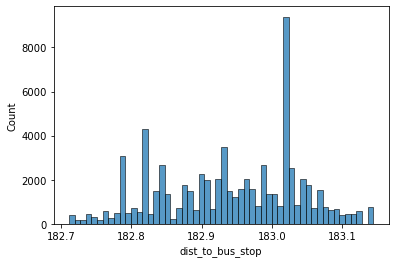

In [39]:
sns.histplot(mcmf.dist_to_bus_stop)

In [26]:
distances = cdist(mcmf_coords, bus_coords, metric='euclidean')

In [28]:
mcmf.shape

(72790, 52)

In [23]:
bus.shape

(10760, 12)

## Old version

In [4]:
mcmf['distance_to_bus_stop'] = None

In [5]:
# Loop through each program in the 'mcmf' dataset
for index, program in mcmf.iterrows():

    # Initialize the minimum distance and nearest bus stop to None
    min_distance = None
    nearest_bus_stop = None

    # Loop through each bus stop in the 'bus' dataset
    for _, bus_stop in bus.iterrows():

        # Calculate the distance between the program and the bus stop using the Haversine formula
        distance = haversine((program['latitude'], program['longitude']), (bus_stop['latitude'], bus_stop['longitude']), unit=Unit.MILES)

        # If the minimum distance is None or the current distance is less than the minimum distance, update the minimum distance and nearest bus stop
        if min_distance is None or distance < min_distance:
            min_distance = distance
            nearest_bus_stop = bus_stop

    # Set the distance to the nearest bus stop for the current program in the 'mcmf' dataset
    mcmf.at[index, 'distance_to_bus_stop'] = min_distance

KeyboardInterrupt: 